In [1]:
import gpflow
import numpy as np
import tensorflow as tf
import tensorflow_probability as tfp
from scipy.integrate import solve_ivp, odeint
from gpflow.utilities import print_summary, positive, to_default_float, set_trainable
from invariance_kernels import ZeroMean, get_MOI, get_damped_pendulum_invariance, get_damped_SHM_invariance
from invariance_functions import degree_of_freedom, get_GPR_model, get_damped_SHM_data, get_damped_pendulum_data, get_grid_of_points_1D, evaluate_model_future, evaluate_model_grid, damped_SHM_dynamics, damped_pendulum_dynamics
import os
os.environ["CUDA_VISIBLE_DEVICES"] = '4'

In [2]:
mean = ZeroMean(2)
time_step = 0.01
training_time = 0.1
testing_time =  1

max_x = 3  
n_train = 1 
train_starting_position = np.random.uniform(-max_x, max_x, (n_train))
train_starting_velocity = np.random.uniform(-max_x/5, max_x/5, (n_train))

print(train_starting_position)
print(train_starting_velocity)
data = get_damped_pendulum_data(0.1, time_step, training_time, 1e-8, train_starting_position, train_starting_velocity) #switch

[2.21884263]
[0.21601104]


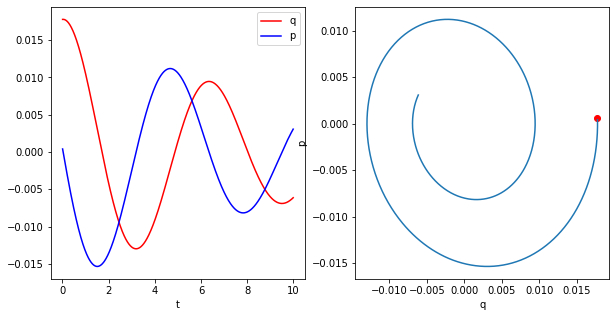

In [25]:
import matplotlib.pyplot as plt
f, (ax1, ax2) = plt.subplots(1, 2,figsize=(10,5))
ax1.plot(np.linspace(0.01, 10-0.01, data[0].shape[0]),data[0][:,0], label="q",color="red")
ax1.plot(np.linspace(0.01, 10-0.01, data[0].shape[0]),data[0][:,1], label="p",color="blue")
ax1.set_xlabel("t")
ax1.legend()
ax2.plot(data[0][:,0],data[0][:,1])
ax2.scatter(np.radians(train_starting_position), np.radians(train_starting_velocity),color="red")
#ax2.scatter(train_starting_position, train_starting_velocity,color="red")
ax2.set_xlabel("q")
ax2.set_ylabel("p")
plt.savefig("figures/damped_shm_trajectory_1D.pdf")

In [18]:

lml_moi = []
lml_inv = []
eva_future_moi = []
eva_future_inv = []
eva_grid_moi = []
eva_grid_inv = []
epsilons = []
for i in range(5):
    test_starting_position = (np.random.uniform(max_x,1+max_x))
#    test_starting_position = np.radians(np.random.uniform(max_x,30+max_x))
    test_starting_velocity = (np.random.uniform(-max_x/5, max_x/5))

    print(test_starting_position)
    print(test_starting_velocity)

    for jitter in [1e-5]:
        moi = get_GPR_model(get_MOI(), mean, data, 500)
        print("%s, "%round(moi.log_marginal_likelihood().numpy()))
        evaluate_moi = evaluate_model_future(moi, test_starting_position, test_starting_velocity, damped_SHM_dynamics, testing_time, time_step)
        print(format(evaluate_moi[0],".4f"))

        lml_moi.append(moi.log_marginal_likelihood().numpy())
        eva_future_moi.append(evaluate_moi[0])
        eva_grid_moi.append(evaluate_model_grid(moi, (4), 40, damped_SHM_dynamics))
        for invar_density in [40]: 
                try:
                    kernel = get_damped_SHM_invariance((5), invar_density, jitter) #switch
                    m = get_GPR_model(kernel, mean, data, 500)
                    print(round(m.log_marginal_likelihood().numpy()))
                    evaluate_invariance = evaluate_model_future(m, test_starting_position, test_starting_velocity, damped_SHM_dynamics, testing_time, time_step)
                    print(format(evaluate_invariance[0],".4f"))
                    print(m.kernel.epsilon.numpy())
                    epsilons.append(m.kernel.epsilon.numpy())
                    lml_inv.append(m.log_marginal_likelihood().numpy())
                    eva_future_inv.append(evaluate_invariance[0])
                    eva_grid_inv.append(evaluate_model_grid(m, (4), 40, damped_SHM_dynamics))
                    

                except tf.errors.InvalidArgumentError:
                    print("jitter too small")
                    break 

    # %%

3.0690090809484243
0.1419430129167839
84, 
1.3052
90
0.1080
1.0035768912372295e-05
3.2537874442677492
0.16505598021695556
84, 
1.4702
90
0.1553
1.0035768912372295e-05
3.514851994915732
-0.00031495340572251784
84, 
1.6815
90
0.2523
1.0035768912372295e-05
3.955791928298462
-0.13755225077913824
84, 
2.1076
90
0.4926
1.0035768912372295e-05
3.8369465919205616
-0.23350736666670674
84, 
1.9708
90
0.4322
1.0035768912372295e-05


In [19]:

print("Baseline RBF & " + format(np.mean(lml_moi),".2f")+" & "+format(np.mean(eva_future_moi),".4f")+" & "+format(np.mean(eva_grid_moi),".4f")+' \\\\')
print("Invariance Kernel & "+ format(np.mean(lml_inv),".2f")+" & "+format(np.mean(eva_future_inv),".4f")+" & "+format(np.mean(eva_grid_inv),".4f")+ ' \\\\')
print(np.mean(epsilons))

Baseline RBF & 84.25 & 1.7071 & 5.7187 \\
Invariance Kernel & 89.51 & 0.2881 & 3.1687 \\
1.0035768912372295e-05


: 

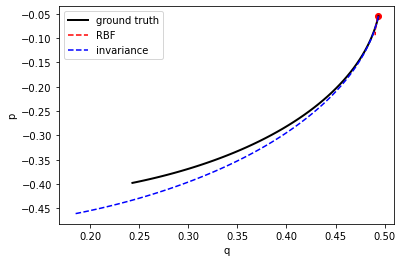

In [13]:
import matplotlib.pyplot as plt
fig, ax = plt.subplots()
plt.plot(evaluate_moi[4][:,0],evaluate_moi[4][:,1], label="ground truth", color="black", linewidth=2)
plt.plot(evaluate_moi[1][:,0],evaluate_moi[1][:,1], "--", label='RBF', color="red")
plt.plot(evaluate_invariance[1][:,0],evaluate_invariance[1][:,1], "--", label="invariance", color="blue")
plt.scatter(evaluate_moi[4][0,0],evaluate_moi[4][0,1],color="red")
plt.xlabel("q")
plt.ylabel("p")
plt.legend()
plt.savefig("figures.damped_shm_predicted_trajectory.pdf")

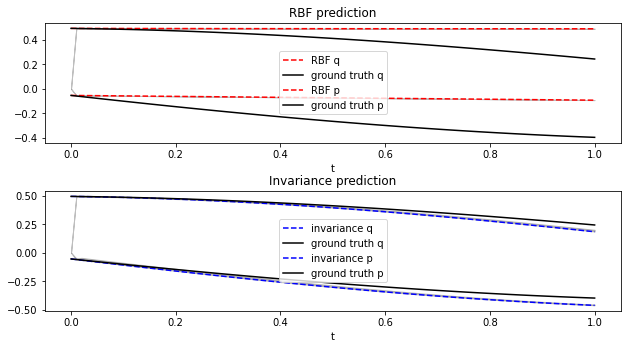

In [14]:

f, (ax1, ax2) = plt.subplots(2, 1,figsize=(10,5))
t = np.linspace(0, testing_time, int(testing_time/time_step))
ax1.plot(t,evaluate_moi[1][:,0],'--',label="RBF q", color="red" )
ax1.plot(t, evaluate_moi[4][:,0], label="ground truth q", color="black")
ax1.fill_between(t,evaluate_moi[2][:,0],evaluate_moi[3][:,0], color="grey", alpha=0.5)
ax1.plot(t,evaluate_moi[1][:,1],'--',label="RBF p", color="red")
ax1.plot(t, evaluate_moi[4][:,1], label="ground truth p", color="black")
ax1.fill_between(t,evaluate_moi[2][:,1],evaluate_moi[3][:,1], color="grey", alpha=0.5)
ax1.set_xlabel("t")
ax1.set_title("RBF prediction")
ax1.legend()

ax2.plot(t,evaluate_invariance[1][:,0], '--', label="invariance q", color="blue")
ax2.plot(t, evaluate_moi[4][:,0],label="ground truth q", color="black")
ax2.fill_between(t,evaluate_invariance[2][:,0],evaluate_invariance[3][:,0], color="grey", alpha=0.5)
ax2.plot(t,evaluate_invariance[1][:,1], '--', label="invariance p", color="blue")
ax2.plot(t, evaluate_moi[4][:,1],label="ground truth p", color="black")
ax2.fill_between(t,evaluate_invariance[2][:,1],evaluate_invariance[3][:,1], color="grey", alpha=0.5)
ax2.set_xlabel("t")
ax2.set_title("Invariance prediction")
ax2.legend()
plt.subplots_adjust(left=0.1,
                    bottom=0.1, 
                    right=0.9, 
                    top=0.9, 
                    wspace=0.4, 
                    hspace=0.4)
plt.savefig("figures/damped_shm_predicted_trajectory_seperate.pdf")

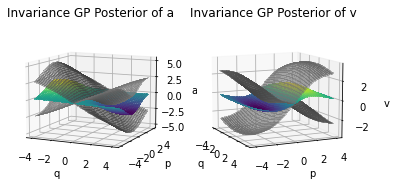

In [17]:
test_range = 4
test_density = 40
test_xs = tf.linspace(-test_range,test_range,test_density)
test_vs = tf.linspace(-test_range,test_range,test_density)
test_xx, test_vv = tf.meshgrid(test_xs, test_vs)
test_points = tf.stack([tf.reshape(test_xx,[-1]), tf.reshape(test_vv,[-1])], axis=1)
pred, var = m.predict_f(test_points) ######switch
X, Y = data
pred_a = pred[:int(pred.shape[0]/2),:]
var_a = var[:int(var.shape[0]/2),:]
pred_v = pred[int(pred.shape[0]/2):,:]
var_v = var[int(var.shape[0]/2):,:]
fig, (ax1, ax2) = plt.subplots(1, 2, subplot_kw={"projection": "3d"})
ax1.plot_surface(test_xx, test_vv, tf.reshape(pred_a, test_xx.shape), cmap="viridis",linewidth=0, antialiased=False, alpha=0.8)
ax1.plot_surface(test_xx, test_vv, tf.reshape(pred_a, test_xx.shape)+1.96*tf.math.sqrt(tf.reshape(var_a, test_xx.shape)), color="grey",linewidth=0, antialiased=False, alpha=0.4)
ax1.plot_surface(test_xx, test_vv, tf.reshape(pred_a, test_xx.shape)-1.96*tf.math.sqrt(tf.reshape(var_a, test_xx.shape)), color="grey",linewidth=0, antialiased=False, alpha=0.4)
ax1.scatter(X[:,0], X[:,1],Y[:,1,None], color="black", marker="o", s=3) #switch for velocity acceleration
ax1.view_init(10,-65)
ax1.set_xlabel("q")
ax1.set_ylabel("p")
ax1.set_zlabel("a") 
ax1.set_title("Invariance GP Posterior of a")

ax2.plot_surface(test_xx, test_vv, tf.reshape(pred_v, test_xx.shape), cmap="viridis",linewidth=0, antialiased=False, alpha=0.8)
ax2.plot_surface(test_xx, test_vv, tf.reshape(pred_v, test_xx.shape)+1.96*tf.math.sqrt(tf.reshape(var_v, test_xx.shape)), color="grey",linewidth=0, antialiased=False, alpha=0.4)
ax2.plot_surface(test_xx, test_vv, tf.reshape(pred_v, test_xx.shape)-1.96*tf.math.sqrt(tf.reshape(var_v, test_xx.shape)), color="grey",linewidth=0, antialiased=False, alpha=0.4)
ax2.scatter(X[:,0], X[:,1],Y[:,0,None], color="black", marker="o", s=3) #switch for velocity acceleration
ax2.view_init(10,-25)
ax2.set_xlabel("q")
ax2.set_ylabel("p")
ax2.set_zlabel("v") 
ax2.set_title("Invariance GP Posterior of v")
plt.savefig("figures/posterior_damped_shm_invariance.pdf")

Text(0.5, 0.92, 'Invariance GP Prior of v')

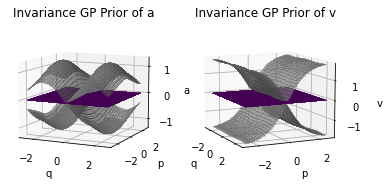

In [21]:
test_range = np.radians(150)
test_density = 40
test_xs = tf.linspace(-test_range,test_range,test_density)
test_vs = tf.linspace(-test_range,test_range,test_density)
test_xx, test_vv = tf.meshgrid(test_xs, test_vs)
test_points = tf.stack([tf.reshape(test_xx,[-1]), tf.reshape(test_vv,[-1])], axis=1)
pred = tf.zeros((test_points.shape[0], 1), dtype=tf.float64)
var = tf.linalg.diag_part(get_damped_pendulum_invariance(np.radians(150), invar_density, jitter)(test_points))
#var = tf.linalg.diag_part(get_SHM_invariance(5, invar_density, jitter)(test_points))
#var = tf.linalg.diag_part(get_MOI()(test_points))
X, Y = data
pred_a = pred
var_a = var[:int(var.shape[0]/2)]
pred_v = pred
var_v = var[int(var.shape[0]/2):]
fig, (ax1, ax2) = plt.subplots(1, 2, subplot_kw={"projection": "3d"})
ax1.plot_surface(test_xx, test_vv, tf.reshape(pred_a, test_xx.shape), cmap="viridis",linewidth=0, antialiased=False, alpha=0.8)
ax1.plot_surface(test_xx, test_vv, tf.reshape(pred_a, test_xx.shape)+1.96*tf.math.sqrt(tf.reshape(var_a, test_xx.shape)), color="grey",linewidth=0, antialiased=False, alpha=0.4)
ax1.plot_surface(test_xx, test_vv, tf.reshape(pred_a, test_xx.shape)-1.96*tf.math.sqrt(tf.reshape(var_a, test_xx.shape)), color="grey",linewidth=0, antialiased=False, alpha=0.4)
#ax1.scatter(X[:,0], X[:,1],Y[:,1,None], color="black", marker="o", s=3) #switch for velocity acceleration
ax1.view_init(10,-65)
ax1.set_xlabel("q")
ax1.set_ylabel("p")
ax1.set_zlabel("a") 
ax1.set_title("Invariance GP Prior of a")

ax2.plot_surface(test_xx, test_vv, tf.reshape(pred_v, test_xx.shape), cmap="viridis",linewidth=0, antialiased=False, alpha=0.8)
ax2.plot_surface(test_xx, test_vv, tf.reshape(pred_v, test_xx.shape)+1.96*tf.math.sqrt(tf.reshape(var_v, test_xx.shape)), color="grey",linewidth=0, antialiased=False, alpha=0.4)
ax2.plot_surface(test_xx, test_vv, tf.reshape(pred_v, test_xx.shape)-1.96*tf.math.sqrt(tf.reshape(var_v, test_xx.shape)), color="grey",linewidth=0, antialiased=False, alpha=0.4)
#ax2.scatter(X[:,0], X[:,1],Y[:,1,None], color="black", marker="o", s=3) #switch for velocity acceleration
ax2.view_init(10,-25)
ax2.set_xlabel("q")
ax2.set_ylabel("p")
ax2.set_zlabel("v") 
ax2.set_title("Invariance GP Prior of v")
#plt.savefig("figures/prior_pendulum_invariance.pdf")